Assignment 3

Name:
Miao Bosen, Riley Andreachuk

CCID:bmiao1, randreac

In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')     # Imports

from google.colab import drive
drive.mount('/content/drive')

import requests
from bs4 import BeautifulSoup

import pandas as pd

def scrape_table(table):
    df = pd.read_html(str(table))
    df = pd.DataFrame(df[0])
    return Table.from_df(df)

Mounted at /content/drive


In [2]:
r = requests.get('https://www.globalproductprices.com/rankings/egg_prices/#:~:text=Based%20on%2081%20countries%20included%20in%20our%20data,is%20for%2012%20pieces%20of%20M-sized%20non-organic%20eggs.')

page = BeautifulSoup(r.text, 'html.parser')  # Create a BeautifulSoup object


all_tables = page.find_all('table') # Allows us to search for a table within the link provided within beautiful soup

census_table = scrape_table(all_tables[0])  # Finds the specific table we are looking for
census_table

<ipython-input-1-89cf845de960>:17: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))


Countries,"Eggs prices, dozen",Rank
New Zealand,6.77,1
Switzerland,5.87,2
Norway,5.4,3
Uruguay,5.35,4
Australia,5.05,5
Bulgaria,4.83,6
South Korea,4.54,7
Sweden,4.36,8
Germany,4.2,9
Belgium,4.1,10


In [3]:
egg = census_table.relabel("Eggs prices, dozen","Price of Dozen Eggs(USD)").take(np.arange(30,40)) # We only need 10 countries for this project, this line picks 10 from the table
                                                                                                  # including Canada
egg

Countries,Price of Dozen Eggs(USD),Rank
Slovakia,3.15,31
Ghana,3.09,32
Croatia,3.05,33
South Africa,2.94,34
Poland,2.94,35
Czechia,2.84,36
Canada,2.78,37
Netherlands,2.73,38
Jordan,2.68,39
Costa Rica,2.6,40


In [4]:
currency_name = make_array("EUR", "HRK", "GHS", "PLN", "ZAR", "CZK", "CAD", "EUR", "JOD", "CRC")  # All the curencys we need for our table (Made the array in order)

In [5]:
egg = egg.with_column("Currency", currency_name)  # making another column with the currency symbols
egg

Countries,Price of Dozen Eggs(USD),Rank,Currency
Slovakia,3.15,31,EUR
Ghana,3.09,32,HRK
Croatia,3.05,33,GHS
South Africa,2.94,34,PLN
Poland,2.94,35,ZAR
Czechia,2.84,36,CZK
Canada,2.78,37,CAD
Netherlands,2.73,38,EUR
Jordan,2.68,39,JOD
Costa Rica,2.6,40,CRC


In [6]:
exchange_rates = {
    "EUR": 0.92,
    "HRK": 6.86,   # exchange rates for counrtries
    "GHS": 10.83,
    "PLN": 4.32,
    "ZAR": 18.60,
    "CZK": 23.26,
    "CAD": 1.36,
    "JOD": 0.71,
    "CRC": 566.30
}
                                             # The table we imported does not have "Local" prices of eggs, This code is needed to work backwards and get that information
def convert_price(price_usd, currency):
  if currency in exchange_rates:
    return price_usd * exchange_rates[currency]  # sets what would happen if a currency symbol from the table matches one from the exchange rates
  else:
    return np.nan



converted_prices = []
for i in range(egg.num_rows):
    price_usd = egg.column('Price of Dozen Eggs(USD)').item(i)
    currency = egg.column("Currency").item(i)                       # creates a list of all the converted currencys, extracts the prices in usd and currency for a row,
    converted_prices.append(convert_price(price_usd, currency))     # Converts the prices to the local currency
egg = egg.with_column('Local Price', converted_prices)              # Creates a new column and adds it to the original


egg

Countries,Price of Dozen Eggs(USD),Rank,Currency,Local Price
Slovakia,3.15,31,EUR,2.898
Ghana,3.09,32,HRK,21.1974
Croatia,3.05,33,GHS,33.0315
South Africa,2.94,34,PLN,12.7008
Poland,2.94,35,ZAR,54.684
Czechia,2.84,36,CZK,66.0584
Canada,2.78,37,CAD,3.7808
Netherlands,2.73,38,EUR,2.5116
Jordan,2.68,39,JOD,1.9028
Costa Rica,2.6,40,CRC,1472.38


In [10]:
gdp=Table.read_table("/content/drive/MyDrive/2024_specific_countries_gdp.csv") # For our external factor we imported a csv with the gross domestic product of each of our selected countries
gdp

Country,2024 GDP (Billion USD)
Slovakia,134.5
Croatia,77.2
Ghana,92.4
Poland,849.2
South Africa,419
Czechia,353.6
Canada,2470
Netherlands,1212
Jordan,55.8
Costa Rica,75.2


In [11]:
egg_joined=egg.join("Countries",gdp,"Country")
egg_joined

Countries,Price of Dozen Eggs(USD),Rank,Currency,Local Price,2024 GDP (Billion USD)
Canada,2.78,37,CAD,3.7808,2470
Costa Rica,2.6,40,CRC,1472.38,75.2
Croatia,3.05,33,GHS,33.0315,77.2
Czechia,2.84,36,CZK,66.0584,353.6
Ghana,3.09,32,HRK,21.1974,92.4
Jordan,2.68,39,JOD,1.9028,55.8
Netherlands,2.73,38,EUR,2.5116,1212
Poland,2.94,35,ZAR,54.684,849.2
Slovakia,3.15,31,EUR,2.898,134.5
South Africa,2.94,34,PLN,12.7008,419


In [12]:
CAD=egg_joined.column("Price of Dozen Eggs(USD)")*1.4 # need to convert USD to CAD

In [13]:
egg_joined=egg_joined.with_column("Price of Dozen Eggs(CAD)",CAD).drop("Price of Dozen Eggs(USD)").drop("Rank") # created another column of but with every price converted to CAD
egg_joined

Countries,Currency,Local Price,2024 GDP (Billion USD),Price of Dozen Eggs(CAD)
Canada,CAD,3.7808,2470,3.892
Costa Rica,CRC,1472.38,75.2,3.64
Croatia,GHS,33.0315,77.2,4.27
Czechia,CZK,66.0584,353.6,3.976
Ghana,HRK,21.1974,92.4,4.326
Jordan,JOD,1.9028,55.8,3.752
Netherlands,EUR,2.5116,1212,3.822
Poland,ZAR,54.684,849.2,4.116
Slovakia,EUR,2.898,134.5,4.41
South Africa,PLN,12.7008,419,4.116


Text(0.5, 1.0, 'GDP (joined countries)')

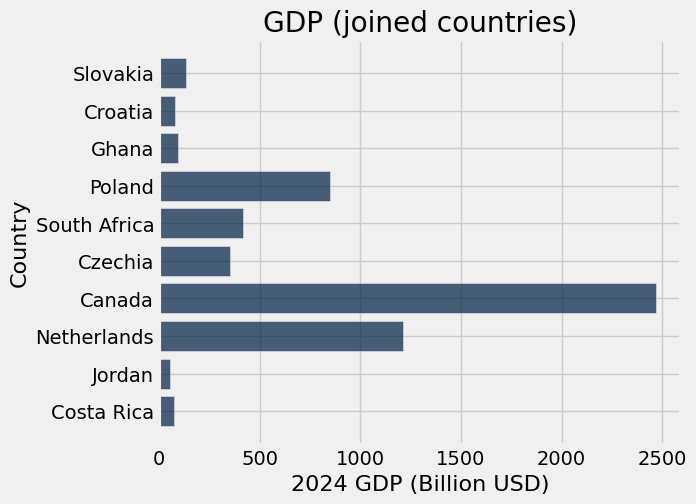

In [14]:
gdp.barh("Country", "2024 GDP (Billion USD)")
plots.title("GDP (joined countries)")

In [15]:
difference=egg_joined.column("Price of Dozen Eggs(CAD)")-3.892
egg_joined=egg_joined.with_column("Price difference",difference)

Text(0.5, 1.0, 'Egg Pricing difference')

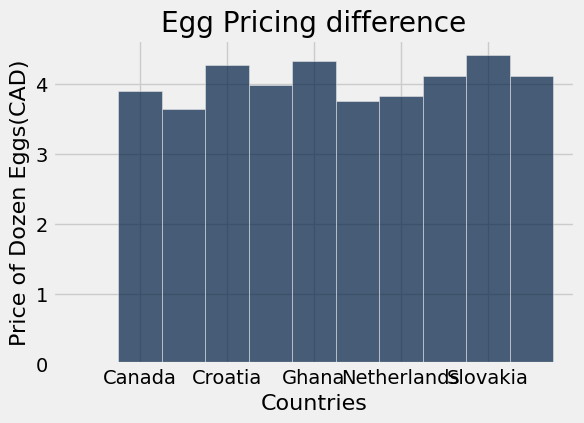

In [16]:
egg_joined.bar("Countries","Price of Dozen Eggs(CAD)")
plots.title("Egg Pricing difference")

Text(0.5, 1.0, 'Price difference')

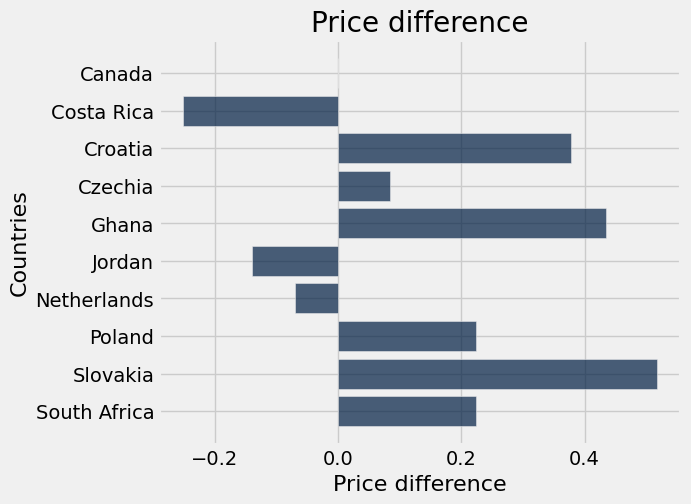

In [17]:
egg_joined.barh("Countries","Price difference") # plotting graph
plots.title("Price difference")

Text(0.5, 1.0, 'Price difference VS GDP')

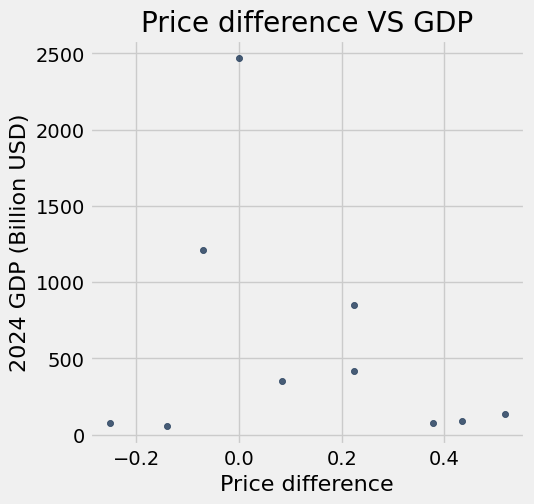

In [18]:
egg_joined.scatter("Price difference","2024 GDP (Billion USD)") #Plotting graph
plots.title("Price difference VS GDP")

In [19]:
def standard_units(arr):
    """ Converts an array to standard units """
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):                                                                         # Functions to find the correlation between the price difrence and GDP of counrties
    """ Computes correlation: t is a table, and x and y are column names """
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

In [20]:
correlation(egg_joined,"Price difference","2024 GDP (Billion USD)")

-0.25851485722281098